In [10]:
# Import libraries
from bs4 import BeautifulSoup
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import names 
from datetime import datetime
import numpy as np
import seaborn as sns
#corpora of male and female names 
male_names = names.words('male.txt')
female_names = names.words('female.txt')

In [11]:
conda install -c conda-forge langdetect

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


Note: At the end of the notebook I do some specific analysis using some data collected. There's randomness involved in collected the data so if you rerun the note book then the analysis at the end mightn't make sense. 

The goal of this project is to create a data frame that could be used for analysis of goodreads reviews. 
There are five basic steps:
1. Scrape URLs of the goodreads pages of books
2. Scrape the wanted data from these goodreads pages
3. Store this data 
4. Preform sentiment analysis on the reviews
5. Store all the data in a pandas dataframe

Each of these steps is preformed in a different function. The function 'scrape_all_genres_and_get_dataset' calls each of these functions and returns the finished dataframe. 

In [12]:
def scrape_all_genres_and_get_dataset(genre_list, book_per_genre_limit, review_limit):
    '''
    Given a list of genres this function scrapes book reviews and the authors name from the goodreads website 
    It uses VADER Sentiment Analysis to get the sentiment of the reviews 
    and returns a dataframe which contains the sentiment score for each book with the genre, authors gender and book id.
    
    parameters: 
        genre_list (list of str): a list of genres
        book_per_genre_limit (int): The max number of books per genre
        review_limit (int): the max number of reviews per book
    
    return: 
        dataframe (pandas.DataFrame): a pandas dataframe with a row for each review and where the columns are the URL for the book, the authors gender, the genre of the book and the sentiment score of the review.
    '''
    #Initialising a list of the URLs for books. 
    all_book_urls= list()
    #A dictionary where the a book's URL is the key and the value is the genre of the book.
    book_genres = dict()
    #all_book_urls is extended with URLs for books in a given genre.
    for genre in genre_list:
        all_book_urls.extend(scrape_book_links_from_genre(genre, book_per_genre_limit, book_genres))
    #scraping and storing the data from the book pages
    parsed_books,titles,author_gender,ratings = scrape_reviews_from_books(all_book_urls, review_limit)
    #Proforming sentiment analysis
    scores = sentiment_analysis(parsed_books)
    #Making a dataframe
    dataframe = make_dataframe(book_genres,scores,titles,author_gender,ratings)
    return(dataframe)

In this project it is necessary to make a http get request multiple times. A http get request is used to request data from a specified source, in this case goodreads. The request library performs the http requests. The response from the http request returns a HTML webpage. A beautiful soup object represents HTML files as nested data structures. This makes it easier to retrieve the data you want from the file. 
Once I have the beautiful soup object of the HTML webpage I can then scrape the information I want from it.

In [13]:
def make_http_get_request(url):
    '''
    This function takes a url and returns a beautiful soup object of the http response content.
    The request library performs the http request. 
    
    parameters:
        url (str): A url to a website
    
    return:
        a beautiful soup object of the http response content
    '''
    log_it('make_http_get_request() start : '+ url)
    link_root = "https://www.goodreads.com"
    headers = requests.utils.default_headers()
    headers.update({ 'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'})
    response = requests.get(link_root + url, headers)
    log_it('make_http_get_request() end : '+ url)
    return(BeautifulSoup(response.content, 'html.parser'))

In [4]:

import requests

url = "https://thevirustracker.com/free-api?global=stats"
response = requests.get(url)
response

b'{\r\n   "results":[\r\n      {\r\n         "total_cases":18167709,\r\n         "total_recovered":11419916,\r\n         "total_unresolved":5699534,\r\n         "total_deaths":691193,\r\n         "total_new_cases_today":159302,\r\n         "total_new_deaths_today":3177,\r\n         "total_active_cases":95804,\r\n         "total_serious_cases":5573170,\r\n         "total_affected_countries":213,\r\n         "source":{\r\n            "url":"https://thevirustracker.com/"\r\n         }\r\n      }\r\n   ],\r\n   "stat":"ok"\r\n}\r\n'

# Step 1: Scrape links
This function creates a beautiful soup object from a goodreads 'shelf' of a given genre. A shelf contains a list of books of said genre. To collect the links to these individual book pages I find all the links with class type 'leftAlignedImage' in the soup.
<br>soup.find_all('a', class_='leftAlignedImage'). <br>
HTML links are defined by the ‘a’ tag and having looked at the page source I saw that the links with the class attribute 'leftAlignedImage' were the links to the individual book pages.
Attributes are a html feature, they provide additional information about an element, elements with the same class attribute have the same style.
Now I have a list of beautiful soup tag elements, one for each book. A HTML element has a start tag, an end tag and the content in between. <br>
< a class="leftAlignedImage" href="/book/show/11588.The_Shining" title="The Shining"><im alt="The Shining" src="https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1353277730l/11588._SY75_.jpg"/></a > <br>
The link address is specified in the ‘href’ attribute. In beautiful soup you can access a tag's attributes like you would a dictionary, tag[attribute]. So I used a list comprehension to get a list of just the link addresses. This is step one complete.<br>
I also update the book_genres dictionary with the book page link as its key and the books genre as the value. This will be useful later when making the dataframe so that I can know the genre of each book.

In [14]:
def scrape_book_links_from_genre(genre, book_per_genre_limit,book_genres):
    '''
    This function makes a http to the goodreads genre page and then scrapes the links for the books for the given genre
    It also makes a dictionary where the keys are the book urls and the values are the genre.
    
    parameters:
        genre (str): A book genre (e.g. fiction)
        book_per_genre_limit (int): the max number of books per genre 
        book_genres (dict): a dictionary
    
    return:
        a list, of size book_per_genre_limit, of the urls to goodreads pages for books in a given genre.
    '''
    soup = make_http_get_request("/shelf/show/" + genre)
    #Finding all the links of class type leftAlignedImage.
    genre_book_raw_links = soup.find_all('a', class_='leftAlignedImage')
    #using beautiful soup the attribute "href" can be indexed
    genre_book_links = [link['href'] for link in genre_book_raw_links[0:book_per_genre_limit]]
    #Making tuples of the link and its genre. 
    genre_tuples =[(link,genre) for link in genre_book_links]
    genre_tuples_dict = dict(genre_tuples)
    book_genres.update(genre_tuples_dict)
    return(genre_book_links)

# Step 2: Scrape data from the goodreads pages
This function scrapes the data from an individual goodreads page. I'll be scraping reviews, star ratings and the authors name. <br>
To get the data I had to first view the goodreads page source and find what attributes are assigned to the data I want. This allows me to separate the wanted data from the full html page. For example class = 'readable' was the attribute assigned to book reviews. I found an attribute for star ratings as well and then zipped both of these lists together. This is so that when I'm removing reviews to clean up the data the corresponding star rating will get removed as well and the right review will be matched to the right star rating. To clean up the reviews I removed reviews not in English and empty reviews. I then took a random sample of the remaining reviews. With that done I could separate the two lists again.
<br>
On good reads ‘liked it' corresponds to a three-star rating, ‘really liked it’ corresponds to a four-star rating and so on. I switched these phrases for their corresponding numbers e.g. 'really liked it' would be changed to 4.
I also need to extract the actual review text from the element I got by finding all the elements where class=readable. Within these elements there are usually two span tags. The first span tag contains a preview of the review, the first 100 words or so. The second span contains the entire review. However, if the review is less than 100 words then there will only be one span tag. Therefore, I found all the span tags in the element and if there were two I got the second, the full review, and if there was only one then I got that one. 
<br>
I then removed the quotes from the reviews as quotes would affect the accuracy of the sentiment analysis. Someone writing a negative review could be quoting a positive part of the book and vice versa. Once the quotes were removed I had a list of just the text of the reviews which is what I wanted. 
<br>
Lastly, I got the authors first name using the same method as I used to get the reviews and star ratings.
<br>
book.find(class_="authorName__container").span.get_text().split()[0]
<br>
When I use ‘.span’ I am using a beautiful soup method to access the tag <span>. In beautiful soup you can access tags with soup.tag. I then return all this scraped data.


In [16]:
def scrape_reviews_from_book(book_url, review_limit):
    '''
    This function scrapes html tag (class=readable) from goodreads book url 
        (e.g. https://www.goodreads.com/book/show/7094569-feed)
    Example of tag this function scrapes 
        <div class="reviewText stacked">
            <span id="reviewTextContainer165644673" class="readable">
                <span id="freeTextContainer7482633495661466782">This book has zombies in it, but to call...>
                </span>
            </span>
        </div>
    Strategy is to look for class="readable", which goodreads assigned attributes to only book reviews
    Then collect a random sample of these reviews and clean the data a bit by removing non English reviews and removing quotes 
    from inside the reviews. 
    It was a similar process to find the authors name and star reviews. 
                    
    parameters:
        book_url (str): A book URL from goodreads, e.g. https://www.goodreads.com/book/show/7094569-feed
        review_limit (int): the max number of reviews per book
    
    return:
        a list of
            reviews (list): a list of reviews of the book in question
            book_url (str): the url for the book
            author_name (str): The authors name
            stars_in_nums (list): a list of the star reviews 
    '''
    # A dict where the key is the Goodreads text and the value is the star rating it corresponds to
    stars_dict = {'did not like it':1,'it was ok':2, 'liked it':3, 'really liked it':4, 'it was amazing':5}
    # A beautiful soup object of the goodreads page
    book = make_http_get_request(book_url)
    #Finding all objects where the class is 'readable' but exclusing the first one as it is the book description and not a review.
    review_list = book.find_all(class_ = 'readable')[1:]
    #Getting the star rating awarded for each review
    raw_star_list = book.find_all(class_ = 'staticStars notranslate')
    #.get_text is a beautiful soup method that allows you to get just the text element of a tag.
    star_list = [star_list.get_text() for star_list in raw_star_list]
    reviews_and_stars = zip(review_list,star_list)
    # Removing empty reviews and reviews not in English. 
    cleaned_reviews_and_stars = [(review,star) for (review,star) in reviews_and_stars if review.span is not None and detect(review.span.get_text())=='en']
    sample_size = review_limit
    if len(cleaned_reviews_and_stars) == 0:
        return(0)
    elif len(cleaned_reviews_and_stars) < sample_size:
        sample_size = len(cleaned_reviews_and_stars)
    #A list of random numbers where the numbers range from 0 to the length of the cleaned reviews. 
    random_nums = np.random.choice(len(cleaned_reviews_and_stars), size =sample_size, replace=False)
    # A random sample of the reviews.
    random_reviews_and_stars = [(cleaned_reviews_and_stars[num]) for num in random_nums]
    reviews_seperated, stars = zip(*random_reviews_and_stars)
    #Converting the star ratings from words into numbers 
    stars_in_nums = [stars_dict[star] for star in stars]
    #Getting the span tag, which contains the review text, from the review element.
    reviews = [review.find_all('span')[1] if len(review.find_all('span')) > 1 else review.find_all('span')[0] for review in reviews_seperated]
    #Finding all the quotes in the review
    book_quotes = [review.find_all('blockquote') for review in reviews]
    reviews_without_quotes = []
    for book_review in book_quotes:
        review_text = reviews[book_quotes.index(book_review)].get_text()
        reviews_without_quotes.append(review_text)
        for quote in book_review:
            quote = quote.get_text()
            review_text = review_text.replace(quote,'')
            reviews_without_quotes[book_quotes.index(book_review)] = review_text
    #Scraping authors name
    author_name = book.find(class_="authorName__container").span.get_text().split()[0]
    return([reviews_without_quotes, book_url,author_name,stars_in_nums])

# Step 3: Storing the data
Now I have all the link addresses for individual book pages and a function to scrape the data I want a page. This function iterates through all of the links collecting the data and storing it in lists and dictionaries so that it is accesible and can be used later.

In [17]:
def scrape_reviews_from_books(urls,review_limit):
    '''
    The function stores all the data scraped from all the URLs in lists and dictionaries 
    
    parameters:
        urls (list): A list of book urls
        review_limit (int): the max number of reviews per book
    
    
    return:
        parsed_books: an list containing all the scraped data for each book
        titles: a list of the all the URLs
        author_gender: a dictionary where the key is the book URL and the value is the authors gender
        ratings: A list of star ratings awarded
    '''
    # Making all my dicts and lists to store the scraped data in
    book_genres = dict()
    author_gender = {}
    parsed_books = []
    titles = []
    ratings = []
    for url in urls:
        #scrape_reviews_from_book scrapes all the wanted data from an individual book page
        details = scrape_reviews_from_book(url,review_limit)
        #If there are no reviews on a page details will be equal to 0
        if details == 0:
            continue
        parsed_books.append(details)
        #details[2] is the authors name
        if details[2] in male_names:
            author_gender[details[1]] = 'Male'
        elif details[2] in female_names:
            author_gender[details[1]] = 'Female'
        else:
            author_gender[details[1]] = 'Unknown'
        # details[1] is the link url
        titles.append(details[1])
        # details[3] is a list of the star ratings given
        ratings.append(details[3])
    return(parsed_books,titles,author_gender,ratings)

# Step 4: Sentiment analysis
Now I have to do sentiment analysis on the reviews. I used Vader to analyse the sentiment of the reviews. Vader has a lexicon of sentiment related words where each word has a value between -4 and 4. It's a valence-based lexicon, it categorises the words as either negative or positive, positive words have a positive value and negative words have a negative value, but it also indicates the intensity of the sentiment. So 'good' has a value of 1.9 and 'excellent' has a value of 2.7. A value of 4 is the most positive and a value of -4 is the most negative. It’s not just a simple bag of words approach though, it doesn't just match the words in a text with the words in the lexicon. It considers grammatical and syntax cues as well. For example, exclamations marks increase the intensity of a sentiment as does capitalisation. It also considers degree modifiers, 'quite good' is less positive than 'very good'. It looks at the trigram before sentiment related words to see if the polarity is flipped because of negations. For example, 'it’s not very good' is a negative sentence despite 'good' being a positive word. 
Vader provides four metrics: positive, negative, neutral and compound. Positive, negative and neutral are the proportion of the text that is in each of those categories. Compound is the sum of the valence scores of the words in the text standardised so that it ranges between -1 and 1 with -1 being the most negative and 1 being the most positive.  

In [18]:
def sentiment_analysis(parsed_books):
    '''
    This function uses VADER to do sentiment analysis of the book reviews. This returns a dictionary for each review. 
                
    parameters:
        parsed_books (list): a list of a list of the reviews for a book, the book url and the authors name
    
    return:
        scores (array): an array where theres a list for each book and in each list theres a dictionary with the sentiment scores for each review
    '''
    new_words = {'compelling': 10, 'creative': 5,'unoriginal': -5,'boring': -10}
    # Instantiate the sentiment intensity analyzer with the existing lexicon
    vader = SentimentIntensityAnalyzer()
    # Update the lexicon
    vader.lexicon.update(new_words)
    # Column names for the dataframe
    columns = ['reviews', 'title', 'author_name','stars']
    # Convert parsed books into a dataframe
    scored_books = pd.DataFrame(parsed_books, columns=columns)
    # Getting the polarity scores for each review for each book
    scores = [[ vader.polarity_scores(review) for review in review_list] for review_list in scored_books.reviews.values]
    return(scores)

# Step 5: Making the dataframe
Now I have all my components I just need to put them together in a data frame. This will allow the information to be easily accessed and used for analysis. Firstly, I add all the additional data into the sentiment dictionary for each review. Then I make a data frame for each book and append them all vertically so the columns remain the same. Now I have a complete dataframe with all the scraped data that can be used for analysis.

In [19]:
def make_dataframe(book_genres,scores,titles,author_gender,ratings):
    '''
    Scores has a dictionary for each review. 
    These dictionaries are then extended to include the genre, author name and book url. 
    Then a pandas dataframe is made out of these dictionaries.
                
    parameters:
        book_genres (dict): A dictionary that has the book urls as the key and the book genre as the value
        scores (array): an array where theres a list for each book and in each list theres a dictionary with the sentiment scores for each review
        titles (list): a list of the book urls
        author_gender(dict): A dict where the key is the book url and the value the authors gender
    
    return:
        dataframe: It has a row for each book review and a column for the authors gender, the book url, the book genre and the sentiment analysis score.
    '''
    log_it('make_dataframe() start : scores size' + str(len(scores)))
    for individual_book in scores:
        i = 0
        for score in individual_book:
            score['title'] = titles[scores.index(individual_book)]
            score['genre'] = book_genres[score['title']]
            score['gender'] = author_gender[score['title']]
            score['star_rating'] = ratings[scores.index(individual_book)][i]
            i += 1
    #A list of dataframes, one dataframe for each book
    data_frame_list = [pd.DataFrame(individual_book) for individual_book in scores]
    #Concatenating all the dataframes vertically so the columns remain the same.
    data_frame_scores = pd.concat(data_frame_list, ignore_index=True)
    log_it('make_dataframe() end')
    return(data_frame_scores)

I created a logging function because the programme takes a long time to run. I wanted to figure out what was making it so slow and if I could make it more efficient. I thought that maybe storing  large amounts of text from the reviews could be a problem as well as the http get requests. I found that it was the http get requests, unsusprisingly, that took a long time. The number of genres times the books per genre determines how long it will take to run. For example if you had 2 genres and 20 books per genres then thats 40 http get requests. The number of reviews per book is pretty inconsequential so I choose to collect large samples of reviews.

In [20]:
def log_it(log_statement):
    log = (str(datetime.now()) + ' :' + log_statement)
    log_list.append(log)

This function scrapes a selection of genres from the goodreads main page if you want to automatically generate your genre list. I prefer to choose the genres myself manually though so that you can have control over the data collected. I choose to do it as more as an exercise, it hasn't had much of an application. 

In [21]:
def get_genre_list(max_genres):
    soup = make_http_get_request('/list/tag/genre')
    genres = soup.find_all('a', class_="actionLinkLite")
    genres = genres[0:max_genres]
    genre_list = [genre.get_text() for genre in genres]
    log_it('get_genre() returns list: '+ str(genre_list))
    return(genre_list)

In [62]:
log_list = []
book_per_genre_limit = 50
review_limit = 200
max_genres = 1
genre_list = get_genre_list(max_genres)
genre_list = ['romance','horror','nonfiction','childrens']
dataframe = scrape_all_genres_and_get_dataset(genre_list, book_per_genre_limit, review_limit)
dataframe.head()


,compound,gender,genre,neg,neu,pos,star_rating,title
0,-0.9813,Female,romance,0.177,0.803,0.020,4,/book/show/1885.Pride_and_Prejudice
1,-0.9813,Female,romance,0.177,0.803,0.020,5,/book/show/1885.Pride_and_Prejudice
2,-0.9813,Female,romance,0.177,0.803,0.020,5,/book/show/1885.Pride_and_Prejudice
3,0.9981,Female,romance,0.062,0.746,0.193,4,/book/show/1885.Pride_and_Prejudice
4,-0.9813,Female,romance,0.177,0.803,0.020,5,/book/show/1885.Pride_and_Prejudice


Below I've written some code to make some graphs of the data

In [39]:
def graph_by_genre(dataframe):
    log_it('graph_by_genre() start')
    plt.style.use("fivethirtyeight")
    %matplotlib inline
    mean_score = dataframe.groupby(['genre']).mean()
    mean_score = mean_score.xs('compound', axis=1)
    mean_score.plot.bar()
    log_it('graph_by_genre() end')

In [65]:
def graph_by_genre_rating(dataframe):
    log_it('graph_by_genre() start')
    plt.style.use("fivethirtyeight")
    %matplotlib inline
    mean_score = dataframe.groupby(['genre']).mean()
    mean_score = mean_score.xs('star_rating', axis=1)
    mean_score.plot.bar()
    log_it('graph_by_genre() end')

In [ ]:
def scatter_plot_genre(dataframe):
    mean_score = dataframe.groupby(['genre','star_rating']).mean().reset_index()
    sns.scatterplot(x="star_rating", y="compound", data=mean_score, hue = 'genre' )

In [28]:
def graph_by_gender(dataframe):
    log_it('graph_by_gender() start')
    %matplotlib inline
    mean_score = dataframe.groupby(['genre','gender']).mean()
    mean_score = mean_score.unstack(level=1)
    # Get the cross-section of compound in the 'columns' axis
    mean_score = mean_score.xs('compound', axis=1)
    # Plot a bar chart with pandas
    mean_score.plot.bar()
    log_it('graph_by_gender() end')

# An application of the data
I thought it would be interesting to see the relationship between the sentiment of reviews and the star rating for different genres. I wanted to see how it varied from genre to genre, for example what would the average sentiment of three-star reviews be for children’s books compared to romance. 
Graph_a is a bar chart that shows the average sentiment of all reviews for the different genres. Graph_b is a bar chart that shows the average star rating of all reviews for the different genres. It's not exactly as you'd expect; star rating doesn't increase linearly with sentiment. For example, horror has a very low average sentiment score but a high average star rating. The opposite is true of romance. Graph_c illustrates this well. You can see there's a general positive correlation between star rating and sentiment however different genres have different lines of best fit. I would argue that there are different reasons behind this. I'd say that for horror and romance this could be due to limitations with the sentiment analysis technology. The Vader sentiment analysis ranked the horror reviews as quite negative, this is probably due to the type of language used to discuss horror books. Vader would rate 'terrifying' or 'horrifying' as negative words but in the context of a horror review that wouldn't be the case. Similarly, when reviewing romance many positive words would have to be used regardless of the overall tone of the review. I would say that this is why the sentiment of the horror reviews is lower on average for the star rating than for the other genres. If a human were to manually rate the sentiment I don't think this would be the case. Nonfiction reviews were on average less positive than children’s book reviews for the same star ratings. I think it could be the same as before in that the content of children’s books is typically more positive than the topics written about in nonfiction books. This would mean that nonfiction book reviews would have to use more negative language regardless of the actual sentiment of the review. However, there could some truth to the relationship as well. I could imagine that children book reviewers could be genuinely more positive across the board than non-fiction reviewers. Non-fiction reviewers could just be less forthcoming with praise and happier to criticise at all star rating levels. 
Overall, I think that this analysis shows a weakness of this type of sentiment analysis, the context of the negative or positive words can't be considered.

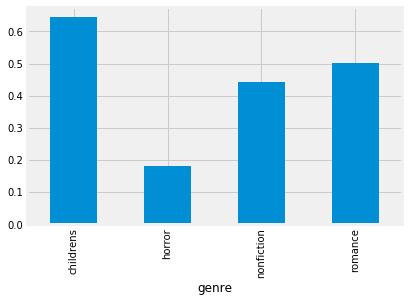

In [79]:
graph_a = graph_by_genre(dataframe)
graph_a

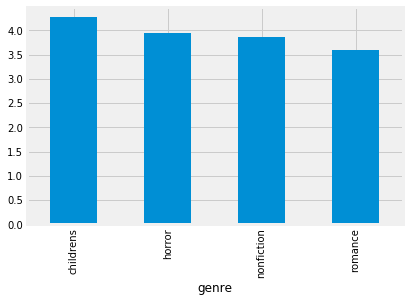

In [81]:
graph_b = graph_by_genre_rating(dataframe)
graph_b 

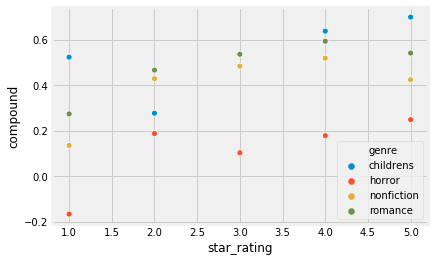

In [82]:
graph_c = scatter_plot_genre(dataframe)
graph_c

Graph d is a graph that shows the sentiment for average sentiment for reviews grouped by genre and authors gender.

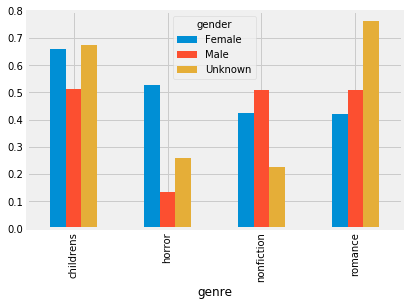

In [86]:
graph_d = graph_by_gender(dataframe)
graph_d

In [291]:
log_list

['2020-05-04 19:52:06.473965 :make_http_get_request() start : /list/tag/genre',
 '2020-05-04 19:52:08.029459 :make_http_get_request() end : /list/tag/genre',
 "2020-05-04 19:52:09.096178 :get_genre() returns list: ['romance']",
 '2020-05-04 19:52:09.096349 :make_http_get_request() start : /shelf/show/comedy',
 '2020-05-04 19:52:11.209392 :make_http_get_request() end : /shelf/show/comedy',
 '2020-05-04 19:52:12.652832 :make_http_get_request() start : /shelf/show/historical fiction',
 '2020-05-04 19:52:14.787735 :make_http_get_request() end : /shelf/show/historical fiction',
 '2020-05-04 19:52:16.383220 :make_http_get_request() start : /book/show/386162.The_Hitchhiker_s_Guide_to_the_Galaxy',
 '2020-05-04 19:52:20.525631 :make_http_get_request() end : /book/show/386162.The_Hitchhiker_s_Guide_to_the_Galaxy',
 '2020-05-04 19:52:23.527814 :make_http_get_request() start : /book/show/9418327-bossypants',
 '2020-05-04 19:52:27.482103 :make_http_get_request() end : /book/show/9418327-bossypants'